# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Ames Housing dataset 

The dataset is available in the file `'ames.csv'`. 

- Import the dataset and examine its dimensions: 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

# Load the Ames housing dataset 
data = pd.read_csv('ames.csv')

# Print the dimensions of data
print(data.shape)

# Check out the info for the dataframe
print(data.info())

# Show the first 5 rows
data.head()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st     

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Identify features and target data 

In this lab, we will use using 3 predictive continuous features:

#### Features

- `LotArea`: Lot size in square feet
- `1stFlrSF`: Size of first floor in square feet
- `GrLivArea`: Above grade (ground) living area square feet

#### Target

- `SalePrice`', the sale price of the home, in dollars

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents of both the features and the target variable

In [2]:
# Features and target data
target = data.SalePrice
features = data[['LotArea', '1stFlrSF', 'GrLivArea']]

## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

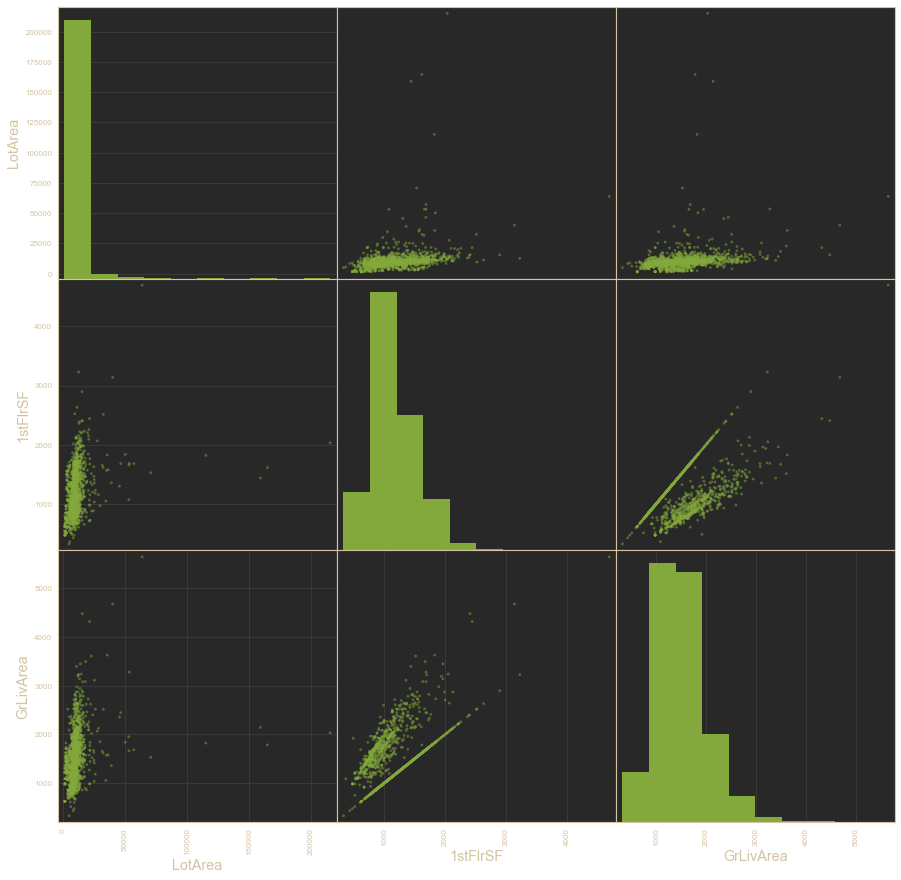

In [6]:
# Your code here 
pd.plotting.scatter_matrix(features, figsize=(15,15));

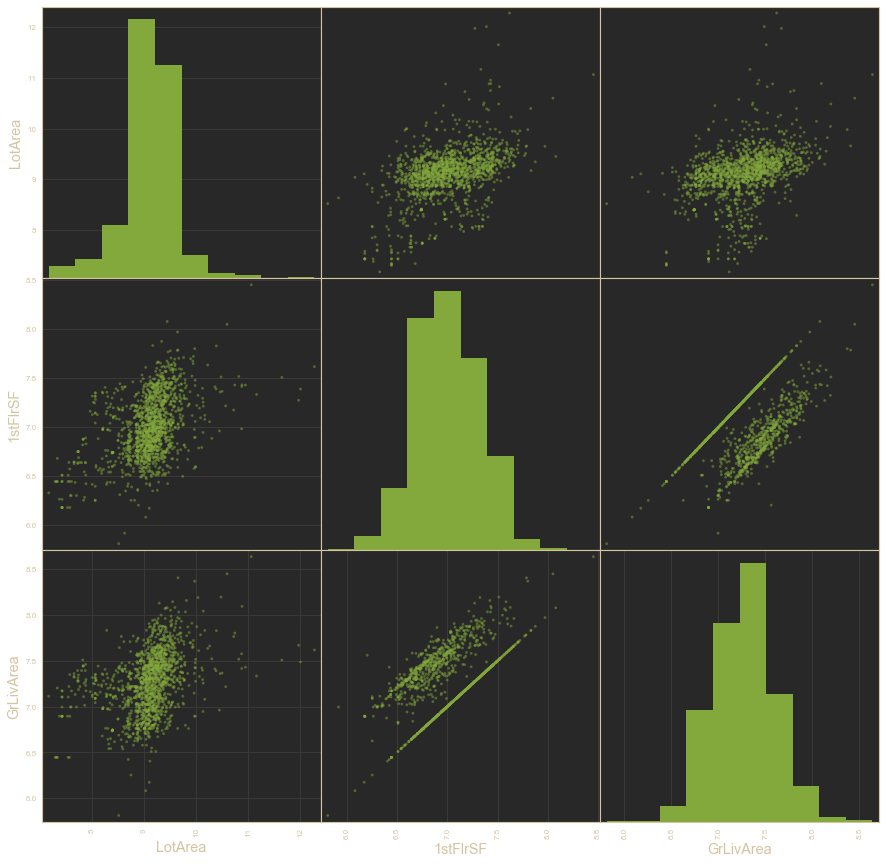

In [8]:
# Outliers are distorting some of the relationships in these scatter plots
# The 1stFlrSF has two groups, one which is perfectly correlated with GrLivArea, and another
# which is correlated, but not perfect. The first of these two groups would be the homes which
# have all of their 1st floor square footage above grade, and the second would be those that
# do not.
# Lot area appears to be correlated with both other variables. A log transformation may make
# this relationship easier to see.
log_features = np.log(features)
pd.plotting.scatter_matrix(log_features, figsize=(15,15));

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return both the R-squared score and Root Mean Squared Error (RMSE) for two equal-sized arrays for the given true and predicted values 
    - Depending on your version of sklearn, in order to get the RMSE score you will need to either set `squared=False` or you will need to take the square root of the output of the `mean_squared_error` function - check out [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) or this helpful and related [StackOverflow post](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)
    - The benefit of calculating RMSE instead of the Mean Squared Error (MSE) is that RMSE is in the same units at the target - here, this means that RMSE will be in dollars, calculating how far off in dollars our predictions are away from the actual prices for homes, on average

In [9]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)
    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = np.sqrt(mean_squared_error(y_true, y_predict))
    # Return the score
    return r2, rmse


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.6870225614927066]

(0.9228556485355649, 0.6870225614927066)

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [11]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.20, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [ ]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

In [12]:
# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

(0.5961521990414137, 55656.48543887347)

In [13]:
X_train_log = np.log(X_train)
X_test_log = np.log(X_test)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [16]:
# Instantiate DecisionTreeregressor_log 
# Set random_state=45
regressor_log = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor_log.fit(X_train_log, y_train_log)

# Make predictions on the test data
y_pred_log = regressor_log.predict(X_test_log)

# Calculate performance using the performance() function 
score = performance(y_test_log, y_pred_log)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

(0.35755126907410295, 0.3462508021246692)

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate RMSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

Max Train R2 0.9998206787060177 at Max Depth of 25
Max Test R2 0.6621757798280998 at Max Depth of 8


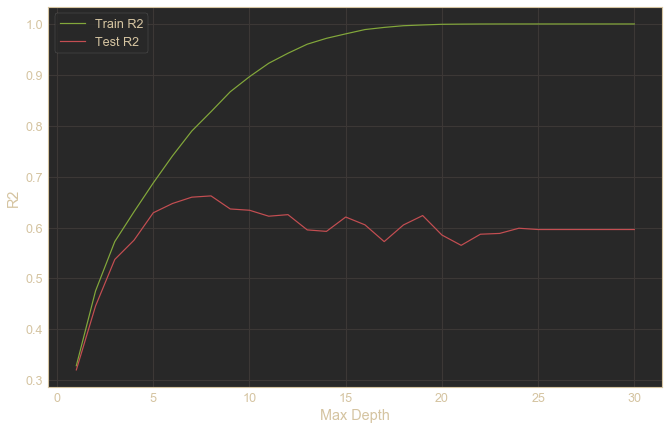

Minimum RMSE 1034.20060535821 at Max Depth of 25
Minimum Test RMSE 50904.04668989568 at Max Depth of 8


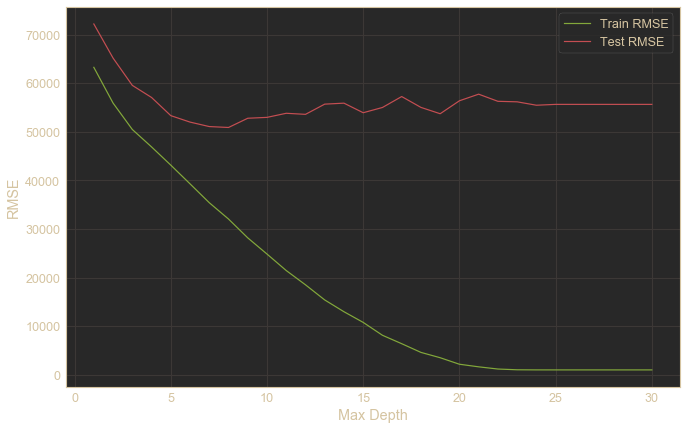

In [20]:
# Your code here 
depths = np.arange(1, 31, 1)
r2_train = np.zeros_like(depths, dtype='float64')
rmse_train = np.zeros_like(depths, dtype='float64')
r2_test = np.zeros_like(depths, dtype='float64')
rmse_test = np.zeros_like(depths, dtype='float64')

for i, depth in enumerate(depths):
    dt = DecisionTreeRegressor(random_state=45, max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    scores = performance(y_train, y_pred)
    r2_train[i] = scores[0]
    rmse_train[i] = scores[1]
    y_pred = dt.predict(X_test)
    scores = performance(y_test, y_pred)
    r2_test[i] = scores[0]
    rmse_test[i] = scores[1]

idxmax_train = np.argmax(r2_train)
print('Max Train R2 {} at Max Depth of {}'.format(r2_train[idxmax_train], 
                                                  depths[idxmax_train]
                                                 ))
idxmax_test = np.argmax(r2_test)
print('Max Test R2 {} at Max Depth of {}'.format(r2_test[idxmax_test],
                                                 depths[idxmax_test]
                                                ))
plt.figure(figsize=(11,7))
plt.plot(depths, r2_train, label='Train R2')
plt.plot(depths, r2_test, label='Test R2')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.show()

rmse_min_train = np.argmin(rmse_train)
print('Minimum RMSE {} at Max Depth of {}'.format(rmse_train[rmse_min_train],
                                                  depths[rmse_min_train]
                                                 ))
rmse_min_test = np.argmin(rmse_test)
print('Minimum Test RMSE {} at Max Depth of {}'.format(rmse_test[rmse_min_test],
                                                       depths[rmse_min_test]
                                                      ))

plt.figure(figsize=(11, 7))
plt.plot(depths, rmse_train, label='Train RMSE')
plt.plot(depths, rmse_test, label='Test RMSE')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

In [ ]:
# It appears that 8 is the ideal max depth

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

Max Train R2 0.9998206787060177 at Min Samples Split of 2
Max Test R2 0.6734642577090126 at Min Samples Split of 10


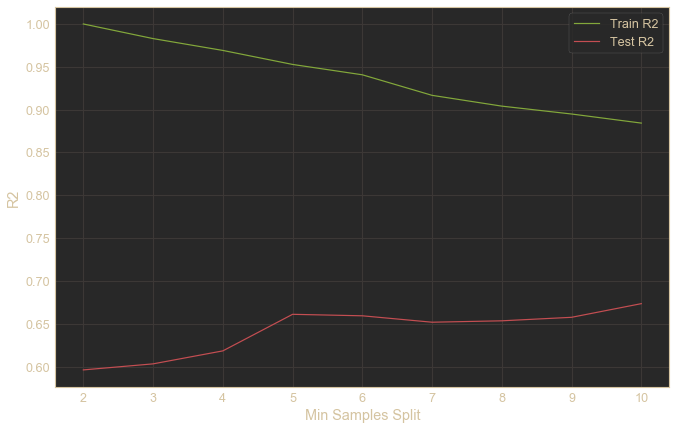

Minimum RMSE 1034.20060535821 at Min Samples Split of 2
Minimum Test RMSE 50046.33514731985 at Min Samples Split of 10


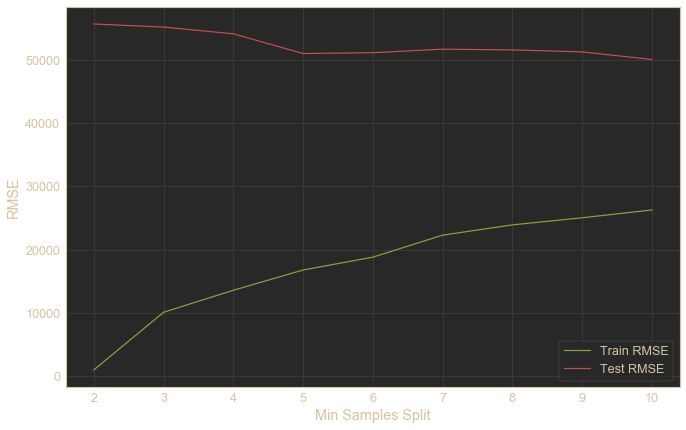

In [23]:
min_samples_splits = np.arange(2, 11, 1)
r2_train = np.zeros_like(min_samples_splits, dtype='float64')
r2_test = np.zeros_like(min_samples_splits, dtype='float64')
rmse_train = np.zeros_like(min_samples_splits, dtype='float64')
rmse_test = np.zeros_like(min_samples_splits, dtype='float64')

for i, min_samples_split in enumerate(min_samples_splits):
    dt = DecisionTreeRegressor(random_state=45, min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    scores = performance(y_train, y_pred)
    r2_train[i] = scores[0]
    rmse_train[i] = scores[1]
    y_pred = dt.predict(X_test)
    scores = performance(y_test, y_pred)
    r2_test[i] = scores[0]
    rmse_test[i] = scores[1]

idxmax_train = np.argmax(r2_train)
print('Max Train R2 {} at Min Samples Split of {}'.format(r2_train[idxmax_train], 
                                                  min_samples_splits[idxmax_train]
                                                 ))
idxmax_test = np.argmax(r2_test)
print('Max Test R2 {} at Min Samples Split of {}'.format(r2_test[idxmax_test],
                                                 min_samples_splits[idxmax_test]
                                                ))
plt.figure(figsize=(11,7))
plt.plot(min_samples_splits, r2_train, label='Train R2')
plt.plot(min_samples_splits, r2_test, label='Test R2')
plt.legend()
plt.xlabel('Min Samples Split')
plt.ylabel('R2')
plt.show()

rmse_min_train = np.argmin(rmse_train)
print('Minimum RMSE {} at Min Samples Split of {}'.format(rmse_train[rmse_min_train],
                                                  min_samples_splits[rmse_min_train]
                                                 ))
rmse_min_test = np.argmin(rmse_test)
print('Minimum Test RMSE {} at Min Samples Split of {}'.format(rmse_test[rmse_min_test],
                                                       min_samples_splits[rmse_min_test]
                                                      ))

plt.figure(figsize=(11, 7))
plt.plot(min_samples_splits, rmse_train, label='Train RMSE')
plt.plot(min_samples_splits, rmse_test, label='Test RMSE')
plt.legend()
plt.xlabel('Min Samples Split')
plt.ylabel('RMSE')
plt.show()

In [ ]:
# Best performance on test set was at 10 min samples split

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [24]:
dt = DecisionTreeRegressor(random_state=45,
                           max_depth=8,
                           min_samples_split=10
                          )
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
performance(y_test, y_pred)

(0.6797912086364211, 49559.11504625333)

In [ ]:
# The R2 and RMSE for the test set has improved using our optimized hyperparameters

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like `max_features` to find a more optimal version of the model 

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

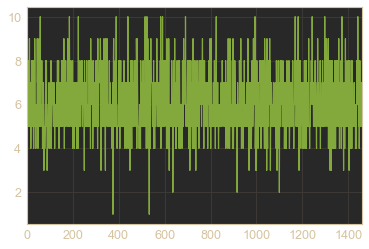

In [26]:
data.OverallQual.plot()

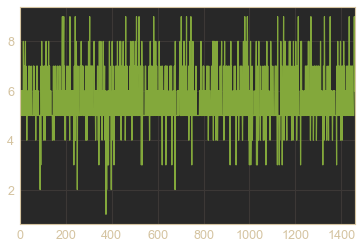

In [27]:
data.OverallCond.plot()

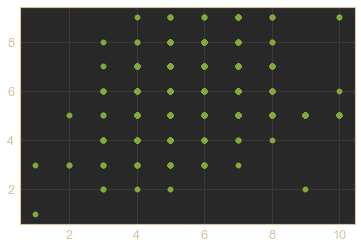

In [28]:
plt.scatter(data.OverallQual, data.OverallCond)

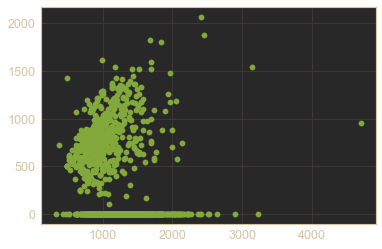

In [29]:
plt.scatter(data['1stFlrSF'], data['2ndFlrSF'])

In [ ]:
# OverallQual and Overall Cond do not seem to be too correlated to use together

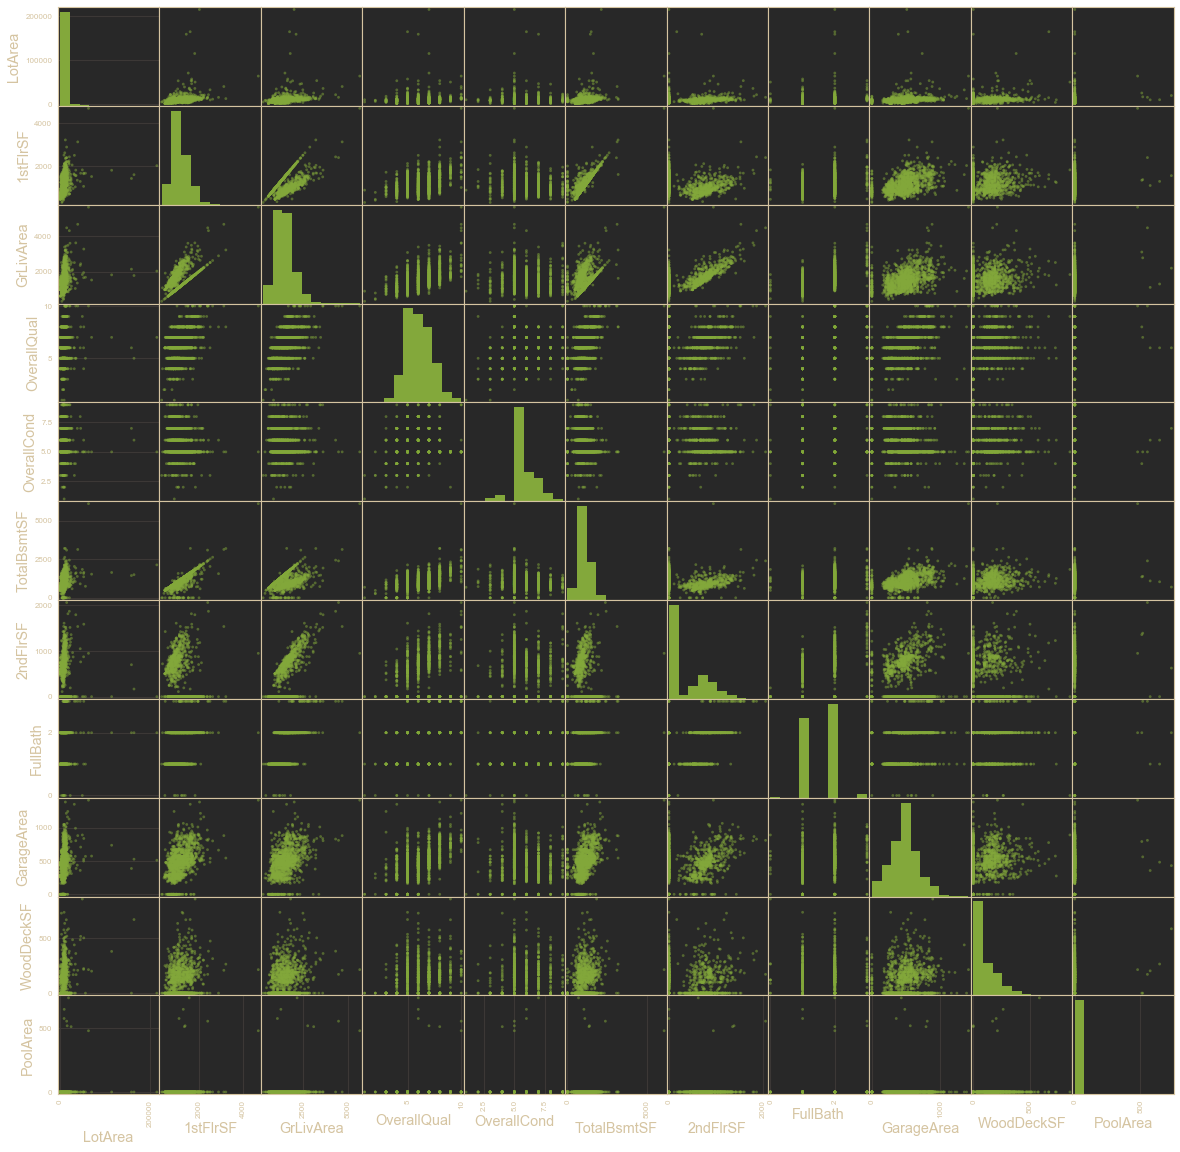

In [31]:
y = data.SalePrice
X = data[['LotArea', '1stFlrSF', 'GrLivArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
          '2ndFlrSF', 'FullBath', 'GarageArea', 'WoodDeckSF', 'PoolArea'
         ]]
pd.plotting.scatter_matrix(X, figsize=(20,20));

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

In [33]:
dt = DecisionTreeRegressor(random_state=45)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
performance(y_test, y_pred)

(0.7306425760535644, 41069.917548739664)

Max Train R2 0.9999631207983487 at Max Depth of 23
Max Test R2 0.7863836766833164 at Max Depth of 6


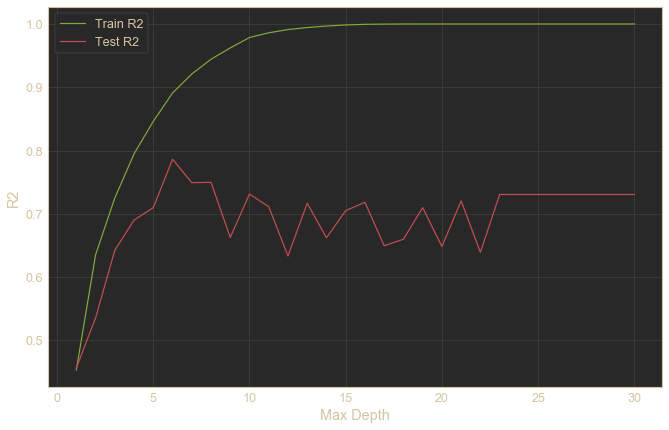

Minimum RMSE 482.82610954130735 at Max Depth of 23
Minimum Test RMSE 36574.34640971965 at Max Depth of 6


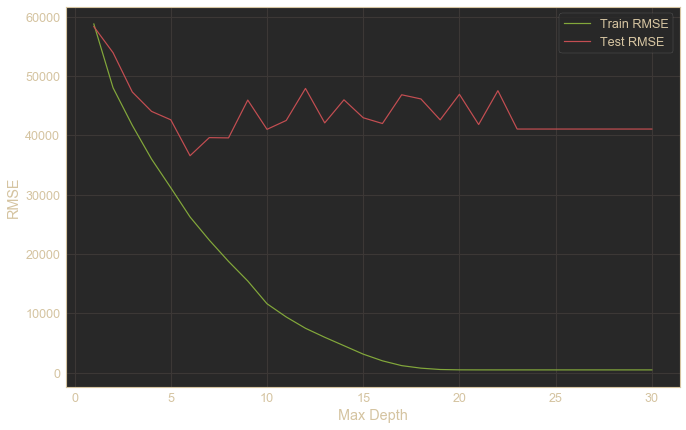

In [34]:
# Your code here 
depths = np.arange(1, 31, 1)
r2_train = np.zeros_like(depths, dtype='float64')
rmse_train = np.zeros_like(depths, dtype='float64')
r2_test = np.zeros_like(depths, dtype='float64')
rmse_test = np.zeros_like(depths, dtype='float64')

for i, depth in enumerate(depths):
    dt = DecisionTreeRegressor(random_state=45, max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    scores = performance(y_train, y_pred)
    r2_train[i] = scores[0]
    rmse_train[i] = scores[1]
    y_pred = dt.predict(X_test)
    scores = performance(y_test, y_pred)
    r2_test[i] = scores[0]
    rmse_test[i] = scores[1]

idxmax_train = np.argmax(r2_train)
print('Max Train R2 {} at Max Depth of {}'.format(r2_train[idxmax_train], 
                                                  depths[idxmax_train]
                                                 ))
idxmax_test = np.argmax(r2_test)
print('Max Test R2 {} at Max Depth of {}'.format(r2_test[idxmax_test],
                                                 depths[idxmax_test]
                                                ))
plt.figure(figsize=(11,7))
plt.plot(depths, r2_train, label='Train R2')
plt.plot(depths, r2_test, label='Test R2')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.show()

rmse_min_train = np.argmin(rmse_train)
print('Minimum RMSE {} at Max Depth of {}'.format(rmse_train[rmse_min_train],
                                                  depths[rmse_min_train]
                                                 ))
rmse_min_test = np.argmin(rmse_test)
print('Minimum Test RMSE {} at Max Depth of {}'.format(rmse_test[rmse_min_test],
                                                       depths[rmse_min_test]
                                                      ))

plt.figure(figsize=(11, 7))
plt.plot(depths, rmse_train, label='Train RMSE')
plt.plot(depths, rmse_test, label='Test RMSE')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

Max Train R2 0.9999631207983487 at Min Samples Split of 2
Max Test R2 0.7594118713231596 at Min Samples Split of 10


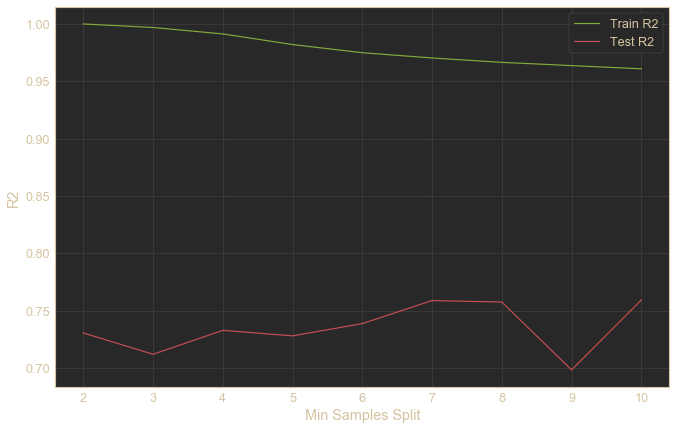

Minimum RMSE 482.82610954130735 at Min Samples Split of 2
Minimum Test RMSE 38814.719595425544 at Min Samples Split of 10


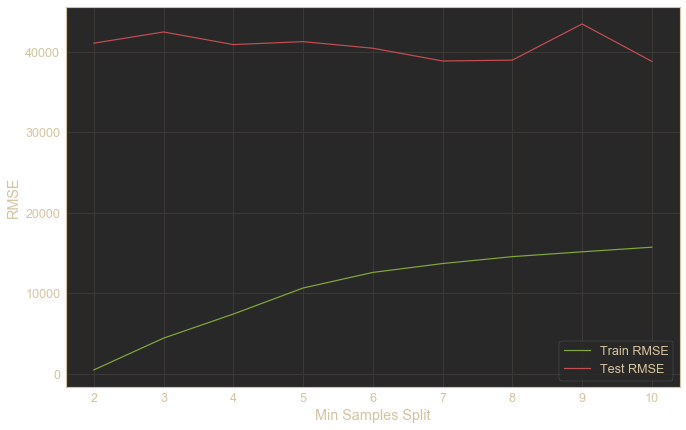

In [35]:
min_samples_splits = np.arange(2, 11, 1)
r2_train = np.zeros_like(min_samples_splits, dtype='float64')
r2_test = np.zeros_like(min_samples_splits, dtype='float64')
rmse_train = np.zeros_like(min_samples_splits, dtype='float64')
rmse_test = np.zeros_like(min_samples_splits, dtype='float64')

for i, min_samples_split in enumerate(min_samples_splits):
    dt = DecisionTreeRegressor(random_state=45, min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_train)
    scores = performance(y_train, y_pred)
    r2_train[i] = scores[0]
    rmse_train[i] = scores[1]
    y_pred = dt.predict(X_test)
    scores = performance(y_test, y_pred)
    r2_test[i] = scores[0]
    rmse_test[i] = scores[1]

idxmax_train = np.argmax(r2_train)
print('Max Train R2 {} at Min Samples Split of {}'.format(r2_train[idxmax_train], 
                                                  min_samples_splits[idxmax_train]
                                                 ))
idxmax_test = np.argmax(r2_test)
print('Max Test R2 {} at Min Samples Split of {}'.format(r2_test[idxmax_test],
                                                 min_samples_splits[idxmax_test]
                                                ))
plt.figure(figsize=(11,7))
plt.plot(min_samples_splits, r2_train, label='Train R2')
plt.plot(min_samples_splits, r2_test, label='Test R2')
plt.legend()
plt.xlabel('Min Samples Split')
plt.ylabel('R2')
plt.show()

rmse_min_train = np.argmin(rmse_train)
print('Minimum RMSE {} at Min Samples Split of {}'.format(rmse_train[rmse_min_train],
                                                  min_samples_splits[rmse_min_train]
                                                 ))
rmse_min_test = np.argmin(rmse_test)
print('Minimum Test RMSE {} at Min Samples Split of {}'.format(rmse_test[rmse_min_test],
                                                       min_samples_splits[rmse_min_test]
                                                      ))

plt.figure(figsize=(11, 7))
plt.plot(min_samples_splits, rmse_train, label='Train RMSE')
plt.plot(min_samples_splits, rmse_test, label='Test RMSE')
plt.legend()
plt.xlabel('Min Samples Split')
plt.ylabel('RMSE')
plt.show()

In [36]:
dt = DecisionTreeRegressor(random_state=45,
                           max_depth=6,
                           min_samples_split=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
performance(y_test, y_pred)

(0.7880539785302769, 36431.07532161574)

In [ ]:
# We can see that the addition of the new predictors and the subsequent search for optimized
# hyperparameters has improved the predictive accuracy of our Decision Tree Regressor.

## Summary 

In this lab, we looked at applying a decision-tree-based regression analysis on the Ames Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 